# **IPCC AR6 data analysis**

In [97]:
using CSV,DataFrames,Statistics,LinearAlgebra,JLD2
using XLSX
using Interpolations
using GLM
using PyPlot,PyCall


In [99]:
tkr=pyimport("matplotlib.ticker")
fm=pyimport("matplotlib.font_manager")
PyPlot.svg(true)
respath="../Manuscript/Results/"
font_prop = fm.FontProperties(fname="/Users/mickael/Library/Fonts/Harding Text Web Regular Regular.ttf",size=10, weight="bold")


PyObject <matplotlib.font_manager.FontProperties object at 0x35defc9a0>

# **0. Data import and utilities**

In [4]:
AR6 = CSV.read("/Users/mickael/Library/CloudStorage/OneDrive-UNSW/Research/Code and data/AR6_data/World.csv/AR6_Scenarios_Database_World_v1.1.csv", DataFrame);


In [5]:
years = parse.(Int, names(AR6)[findfirst(==("2020"), names(AR6)):findfirst(==("2100"), names(AR6))]);
function variables(Model, Scenario,mod=AR6)
    AR6a=filter(row -> row[:Region] == "World" && row[:Model]==Model && row[:Scenario]==Scenario, mod)
    vars=unique(AR6a[!, :Variable])
    XLSX.openxlsx("vars.xlsx", mode="w") do xf
        # Step 5: Write the vector of strings into a specific sheet and range
        sheet = xf[1]  # Access the first sheet
        for (i, str) in enumerate(vars)
            sheet[i, 1] = str  # Write each string into the first column
        end
    end
end
function scenarios(Model)
    AR6a=filter(row -> row[:Region] == "World" && row[:Model]==Model, AR6)
    vars=unique(AR6a[!, :Scenario])
    XLSX.openxlsx("vars.xlsx", mode="w") do xf
        # Step 5: Write the vector of strings into a specific sheet and range
        sheet = xf[1]  # Access the first sheet
        for (i, str) in enumerate(vars)
            sheet[i, 1] = str  # Write each string into the first column
        end
    end
end
function get_vals(Variable::String,Model::String="REMIND-MAgPIE 1.5";
                    Region::String="World",
                    SSP=AR6,
                    scenario=nothing,
                    start_year::String="2020",
                    end_year::String="2100",
                    show::Bool=false)
    
    SSPa=filter(row -> row[:Variable] == Variable && row[:Region] == Region && row[:Model]==Model, SSP)
    if scenario!=nothing
        SSPa=filter(row -> row[:Scenario] == scenario, SSPa)
    end
    # SSPa=filter(row -> row[:Scenario] == "SSP1-19" || row[:Scenario] == "SSP2-19"|| row[:Scenario] == "SSP5-19", SSPa)
    global Scenario=reshape(SSPa[:,"Scenario"], 1, :)
    global Unit=SSPa[1,"Unit"]
    start_idx = findfirst(==(start_year), names(SSPa))
    end_idx = findfirst(==(end_year), names(SSP))
    SSPb=SSPa[:, start_idx:end_idx]

    if show
        p=plot(years,Matrix(SSPb)',
            labels=reshape(Scenario, 1, :),
            ylabel=Unit,mark=(:circle, 5, 0.5))
        display(p)
    end
    return SSPb
end
function get_vals(Variable::String;
                    Region::String="World",
                    SSP=AR6,
                    start_year::String="2020",
                    end_year::String="2100",
                    show::Bool=false)

                    SSPa=filter(row -> row[:Variable] == Variable && row[:Region] == Region, SSP)
                    global Scenario=reshape(SSPa[:,"Scenario"], 1, :)
                    global Unit=SSPa[1,"Unit"]
                    start_idx = findfirst(==(start_year), names(SSPa))
                    end_idx = findfirst(==(end_year), names(SSP))
                    SSPb=SSPa[:, start_idx:end_idx]

                    if show
                    p=plot(years,Matrix(SSPb)',
                    labels=reshape(Scenario, 1, :),
                    ylabel=Unit,
                    # mark=(:circle, 5, 0.5)
                    )
                    display(p)
                    end
                    return SSPb
end


get_vals (generic function with 2 methods)

# **1. AR6 data filtering**


Database search functions

In [54]:
target=1.9
allowed_σ = 0.05 # 5% allowed deviation from the target
targetf=target*(1+allowed_σ)


1.9949999999999999

In [92]:
SSPa = filter(row -> !ismissing(row["2100"]) && row["2100"] <= targetf && row[:Variable] == "AR6 climate diagnostics|Effective Radiative Forcing|MAGICCv7.5.3|50.0th Percentile" && row[:Region] == "World", AR6);


accepted_mods=["REMIND","MESSAGEix-GLOBIOM","POLES","IMAGE","PROMETHEUS","TIAM","REmap","COFFEE","EPPA","McKinsey","GCAM","GMM"]
rejected_mods=["EMF33","CD-LINKS","SSP1-19","SSP2-19","SSP5-19"]


mask = Set((s[:Model], s[:Scenario]) for s in eachrow(SSPa) if any(mod -> occursin(mod, s[:Model]), accepted_mods) && all(mod -> !(occursin(mod, s[:Scenario]) && !(occursin("REMIND", s[:Model]) && occursin("CD-LINKS", s[:Scenario]))), rejected_mods))


AR6a = filter(row -> (row[:Model], row[:Scenario]) in mask, AR6) # filtering the original AR6 database
vars=unique(AR6a[!, :Variable]) ;# getting all the variables available in these models and scenarios


In [96]:
XLSX.openxlsx("vars.xlsx", mode="w") do xf
    sheet = xf[1]
    for (i, v) in enumerate(vars)
        sheet[i, 1] = v
    end
end


In [93]:
AR6a


Row,Model,Scenario,Region,Variable,Unit,1995,1996,1997,1998,1999,2000,2001,2002,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,2026,2027,2028,2029,2030,2031,2032,2033,2034,2035,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048,2049,2050,2051,2052,2053,2054,2055,2056,2057,2058,2059,2060,2061,2062,2063,2064,2065,2066,2067,2068,2069,2070,2071,2072,2073,2074,2075,2076,2077,2078,2079,2080,2081,2082,2083,2084,2085,2086,2087,2088,2089,⋯
,String,String,String7,String,String31,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,Float64?,⋯
1,POLES ADVANCE,ADVANCE_2020_1.5C-2100,World,AR6 climate diagnostics|Effective Radiative Forcing|FaIRv1.6.2|33.0th Percentile,W/m^2,1.60619,1.70688,1.66803,1.76294,1.96323,2.05273,2.06755,2.02792,1.95298,1.99683,1.9576,1.94597,2.00309,2.09834,2.13319,2.20615,2.26652,2.31451,2.43013,2.42785,2.52427,2.55472,2.61475,2.64573,2.674,2.71152,2.79611,2.88325,2.93466,2.98109,2.97911,2.98384,2.98292,2.99071,3.00555,3.01966,3.01213,3.00911,3.02809,3.05892,3.05414,3.05653,3.03152,3.01992,2.98747,2.95457,2.9134,2.89395,2.87794,2.87063,2.88382,2.88554,2.89174,2.87178,2.82964,2.77526,2.74104,2.708,2.6811,2.67227,2.68033,2.69748,2.68815,2.6819,2.67272,2.63837,2.6055,2.57684,2.55808,2.54026,2.53246,2.54455,2.55353,2.55291,2.53233,2.50252,2.46567,2.43872,2.41524,2.38797,2.36878,2.34964,2.34143,2.34357,2.3465,2.3419,2.3274,2.30955,2.27929,2.25581,2.21882,2.18897,2.17028,2.15467,2.16074,⋯
2,POLES ADVANCE,ADVANCE_2020_1.5C-2100,World,AR6 climate diagnostics|Effective Radiative Forcing|FaIRv1.6.2|5.0th Percentile,W/m^2,1.31064,1.41651,1.2735,1.36946,1.65308,1.76319,1.77493,1.69037,1.60853,1.66344,1.61393,1.58601,1.64459,1.75267,1.79194,1.82912,1.91446,1.92776,2.07001,2.0388,2.14249,2.17645,2.23575,2.26922,2.30493,2.34994,2.43453,2.52841,2.58822,2.63687,2.63989,2.64182,2.6475,2.65605,2.67858,2.69431,2.68855,2.69233,2.70859,2.74501,2.74709,2.74765,2.72523,2.71343,2.68383,2.65685,2.62158,2.60138,2.58705,2.58188,2.60083,2.60438,2.60883,2.59143,2.54933,2.49584,2.46311,2.43124,2.40765,2.40004,2.40803,2.4264,2.41738,2.41551,2.40669,2.37286,2.34044,2.31267,2.29359,2.27684,2.27209,2.28876,2.30122,2.302,2.28202,2.25515,2.22345,2.19835,2.17347,2.14534,2.12544,2.10884,2.10344,2.10458,2.11013,2.10734,2.09399,2.07774,2.04635,2.02521,1.98862,1.9627,1.94529,1.93245,1.93821,⋯
3,POLES ADVANCE,ADVANCE_2020_1.5C-2100,World,AR6 climate diagnostics|Effective Radiative Forcing|FaIRv1.6.2|50.0th Percentile,W/m^2,1.72626,1.82928,1.81063,1.90804,2.0833,2.17036,2.18617,2.15782,2.0832,2.12357,2.08628,2.08173,2.13542,2.22527,2.25999,2.3464,2.39676,2.45874,2.56947,2.57477,2.66345,2.69168,2.75122,2.78023,2.811,2.84722,2.93283,3.02288,3.07344,3.11727,3.11362,3.11366,3.11075,3.12045,3.13119,3.13852,3.12461,3.12065,3.13518,3.17115,3.16196,3.16479,3.1367,3.12224,3.08615,3.05293,3.01247,2.98907,2.97318,2.96698,2.98246,2.98533,2.99342,2.97089,2.92652,2.87088,2.83445,2.7996,2.77381,2.76472,2.77279,2.78906,2.77984,2.77436,2.76685,2.73092,2.69691,2.66789,2.64651,2.62894,2.62039,2.63501,2.6452,2.64387,2.62245,2.59104,2.55268,2.52537,2.5014,2.4734,2.45201,2.43243,2.42406,2.42509,2.42915,2.42549,2.41121,2

Now we have a filtered model but still need to add missing values.

In [60]:
function add_missingr(model,scn)
    RM=filter(row -> row[:Model]==model && row[:Scenario]==scn, AR6a)
    filtered_CCS = filter(row -> contains(row[:Variable], "Carbon Sequestration") && count(==('|'), row[:Variable]) <= 1, RM)
        new_rowCCS = DataFrame(filtered_CCS[1, :])
        new_rowCCS[1, :Variable] = "Carbon Sequestration"
        for col in names(filtered_CCS)[6:end]
            new_rowCCS[1, Symbol(col)] = sum(filtered_CCS[:, Symbol(col)])
        end

        filtered_SE = filter(row -> contains(row[:Variable], "Secondary Energy") && count(==('|'), row[:Variable]) <= 1, RM)
        new_rowSE  = DataFrame(filtered_SE[1, :])
        new_rowSE[1, :Variable] = "Secondary Energy"
        for col in names(filtered_SE)[6:end]
            new_rowSE[1, Symbol(col)] = sum(filtered_SE[:, Symbol(col)])
        end
    
        bioCCSsupply = filter(row -> row[:Variable]=="Carbon Sequestration|CCS|Biomass|Energy|Supply", RM)
        CCSsupply = filter(row -> row[:Variable]=="Carbon Sequestration|CCS|Fossil|Energy|Supply", RM)
        Emi_supply = filter(row -> row[:Variable]=="Emissions|CO2|Energy|Supply", RM)
        Emi = filter(row -> row[:Variable]=="Emissions|CO2", RM)
        
        emi_gross_suply= DataFrame(Emi_supply[1, :])
        emi_gross_suply[1, :Variable] = "Emissions|CO2|Gross|Energy|Supply"


        if size(CCSsupply)[1]>0 && size(bioCCSsupply)[1]>0
            emi_gross_suply[!, 6:end] = Emi_supply[!, 6:end] .+ CCSsupply[!, 6:end] .+ bioCCSsupply[!, 6:end]
        elseif size(CCSsupply)[1]>0 && size(bioCCSsupply)[1]==0
            emi_gross_suply[!, 6:end] = Emi_supply[!, 6:end] .+ CCSsupply[!, 6:end]  # .+ bioCCSsupply[!, 6:end]
        elseif size(CCSsupply)[1]==0 && size(bioCCSsupply)[1]>0
            emi_gross_suply[!, 6:end] = Emi_supply[!, 6:end] .+ bioCCSsupply[!, 6:end] # .+ CCSsupply[!, 6:end]
        else 
            println("No CCS option for SE for the model $model and scenario $scn")
            emi_gross_suply[!, 6:end] = Emi_supply[!, 6:end]
        end

        emi_gross= DataFrame(Emi[1, :])
        emi_gross[1, :Variable] = "Emissions|CO2|Gross"
        emi_gross[!, 6:end] = Emi[!, 6:end].+ new_rowCCS[!, 6:end]

        if (model,scn)!=("REMIND 2.1", "CEMICS_HotellingConst_1p5")
            d1=append!(new_rowSE,emi_gross_suply)
            d2=append!(d1,emi_gross)
            return append!(AR6a,d2)
        else
            d1=append!(emi_gross_suply,emi_gross)
            return append!(AR6a,d1)
        end
        # d3=append!(d2,new_rowCCS)
end


add_missingr (generic function with 1 method)

In [61]:
for i in mask
    mod,scn = i
    add_missingr(mod,scn)
end

for i ∈ mask
    mod,scn = i
    println(mod,"-",scn)
end


REMIND 2.1-CEMICS_HotellingConst_1p5
REMIND 1.7-CEMICS-1.5-CDR20
POLES ADVANCE-ADVANCE_2030_1.5C-2100
REMIND-MAgPIE 1.7-3.0-PEP_1p5C_red_eff
REMIND 1.7-ADVANCE_2030_1.5C-2100
REMIND-MAgPIE 1.7-3.0-CD-LINKS_NPi2020_400
REMIND 1.7-CEMICS-1.5-CDR12
REMIND-MAgPIE 1.7-3.0-SMP_1p5C_Def
REMIND-MAgPIE 1.7-3.0-SMP_1p5C_regul
REMIND-MAgPIE 1.7-3.0-PEP_1p5C_full_NDC
REMIND-MAgPIE 1.7-3.0-PEP_1p5C_full_goodpractice
REMIND-MAgPIE 1.7-3.0-SMP_1p5C_Sust
REMIND 1.7-ADVANCE_2020_1.5C-2100
POLES ADVANCE-ADVANCE_2020_1.5C-2100
REMIND-MAgPIE 1.7-3.0-PEP_1p5C_full_eff
REMIND-MAgPIE 1.7-3.0-CD-LINKS_INDC2030i_400
REMIND-MAgPIE 1.7-3.0-SMP_1p5C_lifesty


# **2. Results**

In [62]:
function has_missing_values_in_range(row, year_range)
    for year in year_range
        if ismissing(row[string(year)])
            return true
        end
    end
    return false
end
function interpolate_data(df)

    years_5_step = 2020:5:2060
    years_10_step = 2020:10:2060
    cols_in_range = [string(year) for year in years_5_step if string(year) in names(AR6a)]
    df5=df[:,cols_in_range]|>dropmissing


    year_range5 = 2025:5:2055
    df_filtered = filter(row -> has_missing_values_in_range(row, year_range5), df)

    # Create a matrix for interpolation
    
    df_interpolated = DataFrame()

    # Iterate over each row of the DataFrame
    for i in 1:size(df_filtered, 1)
        # Extract the 10-year step data for the current row
        row_data = df_filtered[i, string.(years_10_step)]
        values = collect(row_data)

        # Create an interpolation function
        itp = interpolate((years_10_step,), values, Gridded(Linear()))

        # Generate the new 5-year step data
        values_5_step = itp.(years_5_step)

        # Create a new DataFrame with the interpolated data
        df_row_interpolated = DataFrame(Row = i, Year = years_5_step, Value = values_5_step)

        # Add the interpolated data to the results DataFrame
        df_interpolated = vcat(df_interpolated, df_row_interpolated)
    end
    # # Reshape the DataFrame back to the original format

    if size(df_interpolated)[1]>0
        df_wide = unstack(df_interpolated, :Year, :Value; combine = first)
        return vcat(df_wide[:,2:end],df5)|>Matrix 
    else
        df_wide = df5
        return df5|>Matrix
    end
   
end
oo=[]
for i ∈ mask
    mod,scn = i
    # println(mod," --> ",scn)
    push!(oo,mod=>scn)
end



In [64]:
function highres(mat)
    original_years = 2020:5:2060
    new_years = 2020:1:2060
    nmat=zeros(length(oo)+3,41)
    for (index, row) in enumerate(eachrow(mat))
        itp = interpolate((original_years,), row, Gridded(Linear()))
        nmat[index,:]= [itp(y) for y in new_years]
    end
    return nmat
end
function pyplotting(mat;color::String="#1e9583",years=2020:5:2060,unit::String="EJ/yr",hlines=nothing,figsize=(8,4))            
    # Calculate statistics
    min_vals = minimum(mat, dims=2)
    max_vals = maximum(mat, dims=2)
    
    median_vals = mapslices(x -> median(x), mat; dims=2)
    q1_valsa = mapslices(x -> quantile(x, 0.25), mat; dims=2)
    q3_valsa = mapslices(x -> quantile(x, 0.75), mat; dims=2)
    
    median_vals = vec(median_vals)
    q1_valsa = vec(q1_valsa)
    q3_valsa = vec(q3_valsa)
    
    q1_vals = mapslices(x -> quantile(x, 0.05), mat; dims=2)
    q3_vals = mapslices(x -> quantile(x, 0.95), mat; dims=2)
    
    q1_vals = vec(q1_vals)
    q3_vals = vec(q3_vals)
    
    ribbon_lower_25_75 = median_vals - q1_valsa  # 25th percentile
    ribbon_upper_25_75 = q3_valsa - median_vals  # 75th percentile
    
    ribbon_lower_5_95 = median_vals - q1_vals  # 5th percentile
    ribbon_upper_5_95 = q3_vals - median_vals  # 95th percentile
    
    ribbon_min = median_vals - vec(min_vals)  # Minimum values
    ribbon_max = vec(max_vals) - median_vals  # Maximum values
    
    # Create a figure and axes
    fig, ax = plt.subplots(figsize=figsize)
    
    ax.plot(years, median_vals, color=color, label="Median Values",lw=2)
    ax.xlim = (2020, 2060)
    ax.fill_between(years, median_vals - ribbon_min, median_vals + ribbon_max, color=color, alpha=0.1,linewidth=0)
    ax.fill_between(years, median_vals - ribbon_lower_5_95, median_vals + ribbon_upper_5_95, color=color, alpha=0.2,linewidth=0)
    ax.fill_between(years, median_vals - ribbon_lower_25_75, median_vals + ribbon_upper_25_75, color=color, alpha=0.4,linewidth=0)
    ax.tick_params(axis="both", direction="in")
    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)
    # display(plt.gcf())
    return fig, ax
end
function pyplotting(mat,ax;color::String="#1e9583",years=2020:5:2060,label=nothing,
                    hlines=nothing,figsize=(8,4))            
    # Calculate statistics
    min_vals = minimum(mat, dims=2)
    max_vals = maximum(mat, dims=2)
    
    median_vals = mapslices(x -> median(x), mat; dims=2)
    q1_valsa = mapslices(x -> quantile(x, 0.25), mat; dims=2)
    q3_valsa = mapslices(x -> quantile(x, 0.75), mat; dims=2)
    
    median_vals = vec(median_vals)
    q1_valsa = vec(q1_valsa)
    q3_valsa = vec(q3_valsa)
    
    q1_vals = mapslices(x -> quantile(x, 0.05), mat; dims=2)
    q3_vals = mapslices(x -> quantile(x, 0.95), mat; dims=2)
    
    q1_vals = vec(q1_vals)
    q3_vals = vec(q3_vals)
    
    ribbon_lower_25_75 = median_vals - q1_valsa  # 25th percentile
    ribbon_upper_25_75 = q3_valsa - median_vals  # 75th percentile
    
    ribbon_lower_5_95 = median_vals - q1_vals  # 5th percentile
    ribbon_upper_5_95 = q3_vals - median_vals  # 95th percentile
    
    ribbon_min = median_vals - vec(min_vals)  # Minimum values
    ribbon_max = vec(max_vals) - median_vals  # Maximum values
    

    if !isnothing(label)
      ax.plot(years, median_vals, color=color, label=label,lw=2)
    else
      ax.plot(years, median_vals, color=color,lw=2)
    end
    ax.xlim = (2020, 2060)
    ax.fill_between(years, median_vals - ribbon_min, median_vals + ribbon_max, color=color, alpha=0.1,linewidth=0)
    ax.fill_between(years, median_vals - ribbon_lower_5_95, median_vals + ribbon_upper_5_95, color=color, alpha=0.2,linewidth=0)
    ax.fill_between(years, median_vals - ribbon_lower_25_75, median_vals + ribbon_upper_25_75, color=color, alpha=0.4,linewidth=0)

    ax.tick_params(axis="both", direction="in")

    ax.spines["top"].set_visible(false)
    ax.spines["right"].set_visible(false)

return ax
end


pyplotting (generic function with 2 methods)

We add the remind pkbudg500 models from premise

In [65]:
Emi_gross_pkbudg500=[44641.11195 39492.43341 20905.4433 11208.96795 7442.745907 5278.255274 4083.153236 3125.641453 2567.169889; 44641.1119538 40177.164397 23420.7451318 12339.9915583 7911.4950168 5759.3371259 4750.306758 4043.1061516 3643.6711149; 44641.1119538 39591.7150774 23365.8463395 14488.7137762 11821.4805898 10384.1136199 10037.4923748 8869.8959751 7971.2666207]

Emi_pkbudg500=[44616.25195 39469.64475 20454.05812 9496.443621 3862.828008 369.4425009 -1567.67999 -2929.832658 -4093.424722; 44616.2519538 40152.2491748 22672.9384198 9501.8833427 1857.7118983 -2560.6620808 -5075.1138927 -6495.1703097 -7781.1963146; 44616.2519538 39564.1244578 22366.943601 9917.4145218 2507.5617807 -3173.5778239 -7417.7301155 -11099.1927508 -16833.9132231]

EmiSE_pkbudg500=[16632.67956 14728.13543 6314.233601 2241.037412 992.8833906 533.2242251 380.977236 309.9137414 255.761281; 16632.6795641 14568.4851897 6222.8445018 2203.7289374 1060.5982829 594.3003708 459.0500633 407.774579 361.0473744; 16632.6795641 14132.1843167 5904.1674262 2580.3033234 1653.3606032 1247.5578203 1176.9368584 1083.0956401 949.6454717]

SE_pkbudg500=[466.7962452 467.4243046 363.0376186 342.992596 330.0956403 335.0195645 356.2120326 385.0719424 432.0789645; 466.7962452 480.4452509 422.3349838 402.7218424 400.4308302 423.1979044 465.6979029 521.2364006 619.717943; 466.7962452 477.7226467 454.3541432 495.3485144 575.3766051 699.740549 894.968737 1161.0186665 1610.0890171]

SEH2_pkbudg500=[0.4691734 1.9023285 3.5253045 7.1634048 13.6096765 23.8912816 36.1180527 49.9225485 65.846286; 0.4691734 2.1014054 5.5785089 14.289327 27.7160264 42.1323451 58.5733754 77.4520602 105.3569656; 0.4691734 2.2304332 7.3951386 21.5259224 47.2224963 84.6950406 143.9520783 230.7985653 378.5513081]
;


In [79]:
Emi=interpolate_data(get_vals("Emissions|CO2",SSP=AR6a))
Emi=vcat(Emi,Emi_pkbudg500)#|> highres # add the pkbudg500 values and interpolate data to 1 year resolution
cumEmi=cumsum(Emi,dims=2).*1e-3 # cummulative sum of emissions in GtCO2
#--
Emi_gross=interpolate_data(get_vals("Emissions|CO2|Gross",SSP=AR6a))
Emi_gross=vcat(Emi_gross,Emi_gross_pkbudg500)#|> highres
#--
cumEmi_gross=cumsum(Emi_gross,dims=2).*1e-3
EmiSE=interpolate_data(get_vals("Emissions|CO2|Gross|Energy|Supply",SSP=AR6a))
EmiSE=vcat(EmiSE,EmiSE_pkbudg500)#|> highres
#--
SE=interpolate_data(get_vals("Secondary Energy",SSP=AR6a))
SE=vcat(SE,SE_pkbudg500)#|> highres
#--
SEH2=interpolate_data(get_vals("Secondary Energy|Hydrogen",SSP=AR6a))
SEH2=vcat(SEH2,SEH2_pkbudg500)#|> highres


20×9 Matrix{Float64}:
 0.133504  0.478595  0.862593   2.03087  …    7.91653   10.9368   14.2942
 0.133501  0.429756  0.747827   2.06768       8.48177   11.6868   15.7592
 0.4273    0.5685    1.8663     5.7065       29.4017    36.1654   41.2741
 0.4273    0.4395    0.6888     2.162        31.6855    38.0447   43.6885
 0.4414    0.8998    3.2112     8.1736       31.8432    36.8041   38.8311
 0.4414    0.6685    2.0805     6.3273   …   44.2541    64.3734   85.3379
 0.4962    0.9347    3.3715     9.8175       61.6364    89.069   112.844
 0.4213    0.443     0.7187     2.1707       30.9149    37.978    43.9423
 0.4213    0.5584    1.7809     5.2554       26.5821    33.7052   39.1813
 0.427     0.4326    0.668      2.0635       30.1286    37.1504   42.9293
 0.4316    0.6384    1.8279     5.1591   …   27.0729    34.1708   39.1323
 0.4307    0.4213    0.7084     2.1468       28.287     35.209    40.617
 0.4316    1.1747    5.3016    14.6107       33.3101    37.5968   40.6167
 0.3906    0.5896 

In [81]:
#--
EJ_to_kwh=1/3.6e-12
LHVH2=33.33 # kWh/kgH2
EJH2_to_kgH2=1*EJ_to_kwh/LHVH2

kgH2=SEH2.*EJH2_to_kgH2 # mass H2
MtH2=kgH2.*1e-9 # mass H2 to Mt H2
GtH2=kgH2.*1e-12 # mass H2 to Gt H2


20×9 Matrix{Float64}:
 0.00111265  0.00398869  0.00718899  …  0.0659777  0.0911492  0.11913
 0.00111262  0.00358166  0.00623252     0.0706885  0.0973994  0.13134
 0.00356119  0.00473797  0.0155541      0.245039   0.301408   0.343985
 0.00356119  0.00366287  0.00574057     0.264072   0.317071   0.364107
 0.0036787   0.00749908  0.0267627      0.265387   0.306732   0.323625
 0.0036787   0.00557139  0.0173392   …  0.368821   0.536499   0.71122
 0.00413541  0.00778995  0.0280986      0.513688   0.742316   0.940462
 0.00351118  0.00369204  0.00598977     0.25765    0.316515   0.366222
 0.00351118  0.0046538   0.0148423      0.22154    0.280905   0.326543
 0.00355869  0.00360536  0.00556722     0.251097   0.309618   0.35778
 0.00359703  0.00532053  0.015234    …  0.22563    0.284785   0.326135
 0.00358953  0.00351118  0.00590392     0.235749   0.293438   0.338509
 0.00359703  0.00979015  0.0441844      0.277612   0.313338   0.338506
 0.00325533  0.00491382  0.0130796      0.185185   0.244144

In [ ]:
#-- allocation principle
AP=(EmiSE./Emi_gross).*(SEH2./SE)
AP1=(EmiSE./Emi_gross).*(SEH2./SE)
SAP=(AP./kgH2)[:,2:end-2]


20×6 Matrix{Float64}:
 9.64562e-14  7.17397e-14  5.01926e-14  3.71317e-14  3.76581e-14  4.13131e-14
 8.97035e-14  7.75163e-14  5.30167e-14  4.3123e-14   4.61334e-14  5.69607e-14
 7.20952e-14  7.05479e-14  7.45242e-14  8.82751e-14  1.17305e-13  1.32187e-13
 9.63909e-14  8.50085e-14  5.1009e-14   3.95633e-14  3.98534e-14  3.67576e-14
 9.04816e-14  8.80927e-14  9.21146e-14  8.93458e-14  5.96301e-14  4.42072e-14
 9.63508e-14  7.56869e-14  4.69806e-14  2.94757e-14  2.30078e-14  2.0511e-14
 9.42729e-14  8.44717e-14  5.26036e-14  4.74446e-14  6.16658e-14  7.45488e-14
 7.81426e-14  5.70909e-14  4.09454e-14  3.39142e-14  3.04547e-14  2.95696e-14
 7.74311e-14  5.46888e-14  3.70752e-14  3.05698e-14  2.72444e-14  2.60416e-14
 9.0055e-14   8.72523e-14  8.2762e-14   7.12724e-14  4.54918e-14  3.21015e-14
 9.18466e-14  8.8672e-14   8.08787e-14  6.63079e-14  4.51379e-14  3.70544e-14
 7.10944e-14  5.66602e-14  4.41369e-14  3.72357e-14  3.65854e-14  3.92202e-14
 8.7235e-14   7.29165e-14  5.07009e-14  3.5

In [ ]:
#-- Export
SAP_exp = SAP
AP1_exp = AP1
@save respath*"AR6/SAP.jld" SAP_exp
@save respath*"AR6/AP.jld" AP1_exp
;


┌ Warning: Opening file with JLD2.MmapIO failed, falling back to IOStream
└ @ JLD2 /Users/mickael/.julia/packages/JLD2/bfPAo/src/JLD2.jl:171


SystemError: SystemError: opening file "../Manuscript/Results/AR6/SAP.jld": No such file or directory

Now we redo the same but increasing the number of points by linear interpolation.

In [83]:
# Emi=interpolate_data(get_vals("Emissions|CO2",SSP=AR6a))
# Emi=vcat(Emi,Emi_pkbudg500)|> highres # add the pkbudg500 values and interpolate data to 1 year resolution
# cumEmi=cumsum(Emi,dims=2).*1e-3 # cummulative sum of emissions in GtCO2
# #--
# Emi_gross=interpolate_data(get_vals("Emissions|CO2|Gross",SSP=AR6a))
# Emi_gross=vcat(Emi_gross,Emi_gross_pkbudg500)|> highres
# #--
# cumEmi_gross=cumsum(Emi_gross,dims=2).*1e-3
# EmiSE=interpolate_data(get_vals("Emissions|CO2|Gross|Energy|Supply",SSP=AR6a))
# EmiSE=vcat(EmiSE,EmiSE_pkbudg500)|> highres
# #--
# SE=interpolate_data(get_vals("Secondary Energy",SSP=AR6a))
# SE=vcat(SE,SE_pkbudg500)|> highres
# #--
# SEH2=interpolate_data(get_vals("Secondary Energy|Hydrogen",SSP=AR6a))
# SEH2=vcat(SEH2,SEH2_pkbudg500)|> highres

# #--
# EJ_to_kwh=1/3.6e-12
# LHVH2=33.33 # kWh/kgH2
# EJH2_to_kgH2=1*EJ_to_kwh/LHVH2

# kgH2=SEH2.*EJH2_to_kgH2 # mass H2
# MtH2=kgH2.*1e-9 # mass H2 to Mt H2
# GtH2=kgH2.*1e-12 # mass H2 to Gt H2

# MtH2_pkbudg=(highres(SEH2_pkbudg500).*EJH2_to_kgH2.*1e-9)[1:3,:]
# #--
# cummH2=cumsum(GtH2,dims=2)
# Emi_gross_pkbudg500hr=highres(Emi_gross_pkbudg500)[1:3,:]
# cumEmi_gross_pkbudg500hr=cumsum(Emi_gross_pkbudg500hr,dims=2).*1e-3
# Emi_pkbudg500hr=highres(Emi_pkbudg500)[1:3,:]
# cumEmi_pkbudg500hr=cumsum(Emi_pkbudg500hr,dims=2).*1e-3

# #-- allocation principle
# AP=(EmiSE./Emi_gross).*(SEH2./SE)
# AP_pkbudg500=(EmiSE_pkbudg500./Emi_gross_pkbudg500).*(SEH2_pkbudg500./SE_pkbudg500)|> highres
# AP_pkbudg500=AP_pkbudg500[1:3,:]
# SAP=AP./kgH2


now we plot the climate targets

In [25]:
GSTA=get_vals("AR6 climate diagnostics|Surface Temperature (GSAT)|MAGICCv7.5.3|50.0th Percentile",SSP=AR6a)|>Matrix
RF=get_vals("AR6 climate diagnostics|Effective Radiative Forcing|MAGICCv7.5.3|50.0th Percentile",SSP=AR6a)|>Matrix
;


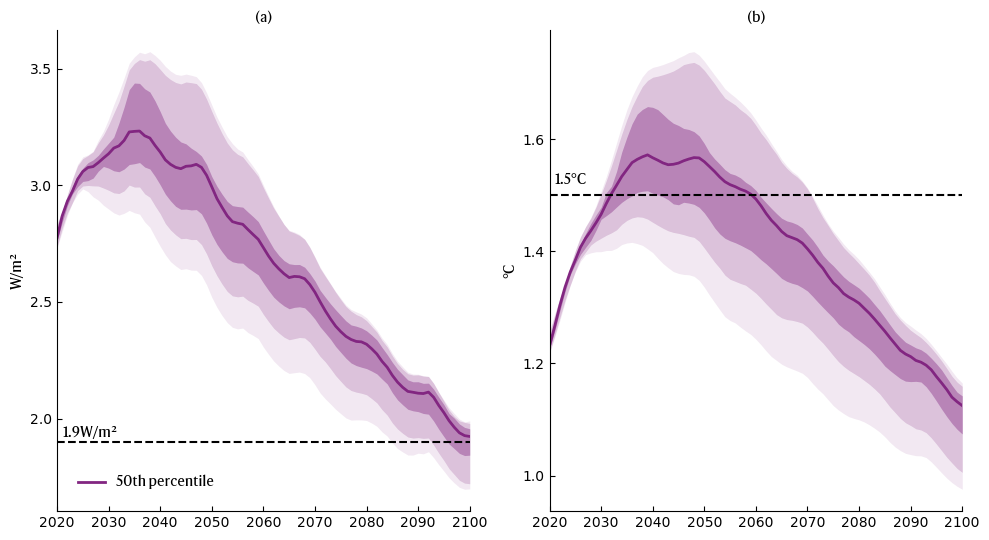

In [26]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5.5),facecolor="none")
fig.subplots_adjust(wspace=0.4)  
for ax in axs
    ax.set_facecolor("none")
end

for (axi,mat,l) in  zip(axs,[RF,GSTA],["50th percentile",nothing,nothing])
    pyplotting(mat',axi,color="#822681",years=collect(2020:1:2100),label=l,hlines=[0],figsize=(5,6));
end
axs[1].axhline([1.9],color="black",linestyle="--",xmax=1)
axs[2].axhline([1.5],color="black",linestyle="--",xmax=1)
axs[1].annotate("1.9W/m²", xy=(2021, 1.92), xytext=(2021, 1.92), fontsize=10, fontproperties=font_prop)
axs[2].annotate("1.5°C", xy=(2021, 1.52), xytext=(2021, 1.52), fontsize=10, fontproperties=font_prop)
axs[1].set_ylabel("W/m²", fontproperties=font_prop)
axs[2].set_ylabel("°C", fontproperties=font_prop)
axs[1].yaxis.set_major_locator(tkr.MaxNLocator(integer=false, nbins=5))
axs[2].yaxis.set_major_locator(tkr.MaxNLocator(integer=false, nbins=5))
axs[1].set_xlim(2020, 2100)
axs[2].set_xlim(2020, 2100)
axs[1].set_title("(a)", fontproperties=font_prop)
axs[2].set_title("(b)", fontproperties=font_prop)

fig.tight_layout()
fig.legend(frameon=false,loc="upper left", bbox_to_anchor=(0.07, 0.15), ncol=5, prop=font_prop)
display(plt.gcf())
# fig.savefig(respath*"climate_vars.svg", bbox_inches="tight",transparent=true)
plt.close("all")


In [27]:
A,B,C,D = plt.figure(figsize=(10, 5.5),facecolor="none",layout="constrained").subplot_mosaic(
                                        "ABCD",
                                        width_ratios=[1,1,1,0.3])
                                        axs=[B,A,C,D]
                                        axs=[i[2] for i in axs]

for (axi,mat,l) in  zip(axs,[cumEmi,MtH2,AP.*100],[nothing,"50th percentile",nothing])
    pyplotting((mat[:,1:end-10])',axi,color="#822681",years=collect(2020:1:2050),label=l,hlines=[0],figsize=(5,6));
end

axs[1].set_ylim(50, 900)
axs[1].set_xlim(2020, 2050)
axs[1].axhline([500],color="black",linestyle="--",xmax=1)
for (i,k,l) in zip(1:3,["yellow","orange","purple"],["pkbudg500-SSP1","pkbudg500-SSP2","pkbudg500-SSP5"])
    axs[1].plot(collect(2020:1:2050),(cumEmi_pkbudg500hr[:,1:end-10][i,:])',color=k,linestyle="-.",label=l,lw=2)
end
axs[1].annotate("500GtCO₂", xy=(2021, 510), xytext=(2021, 510), fontsize=10, fontproperties=font_prop)
axs[1].set_ylabel("GtCO₂/yr", fontproperties=font_prop)
axs[1].set_title("(a)", fontproperties=font_prop)


for (i,k,l) in zip(1:3,["yellow","orange","purple"],["pkbudg500-SSP1","pkbudg500-SSP2","pkbudg500-SSP5"])
    axs[2].plot(collect(2020:1:2050),(MtH2_pkbudg[:,1:end-10][i,:])',color=k,linestyle="-.",lw=2,label=l)
end
IEA_years=[2030, 2035, 2050]
IEA_vals=[66, 152, 401]#.*EJH2_to_kgH2*1.e-9
axs[2].plot(IEA_years,IEA_vals,label="IEA NZE 2050",color="red",linestyle="--",lw=2)
axs[2].set_xlim(2020, 2050)
axs[2].set_ylabel("MtH₂/yr", fontproperties=font_prop)
axs[2].set_ylim(-15, 1200)
axs[2].set_title("(b)", fontproperties=font_prop)

for (i,k) in zip(1:3,["yellow","orange","purple"])
    axs[3].plot(collect(2020:1:2050),(AP_pkbudg500[:,1:end-10][i,:]).*100',color=k,linestyle="-.",lw=2)
end

axs[3].set_xlim(2020, 2050)
axs[3].set_ylabel("%SOS/yr", fontproperties=font_prop)
axs[3].set_ylim(-0.0005.*100, 0.04.*100)
axs[3].set_title("(c)", fontproperties=font_prop)


vect=mean(AP[:,1:end-10],dims=2)
minvect=minimum(vect)*100
maxvect=maximum(vect)*100
median_val=median(vect)*100
Q1 = mapslices(x -> quantile(x, 0.05), vect; dims=1)*100
Q3 = mapslices(x -> quantile(x, 0.95), vect; dims=1)*100

axs[4].axhline([median_val],color="#822681",linestyle="-", xmin=0, xmax=1,lw=2)
axs[4].fill_between(x=[0, 1], y1=minvect, y2=maxvect, color="#822681", alpha=0.1)
axs[4].fill_between(x=[0, 1], y1=Q1[1], y2=Q3[1], color="#822681", alpha=0.2)
Q1 = mapslices(x -> quantile(x, 0.25), vect; dims=1)*100
Q3 = mapslices(x -> quantile(x, 0.75), vect; dims=1)*100
axs[4].fill_between(x=[0, 1], y1=Q1[1], y2=Q3[1], color="#822681", alpha=0.4)
axs[4].set_ylabel("%SOS", fontproperties=font_prop)
axs[4].set_title("(d)", fontproperties=font_prop)
axs[4].set_xticks([])

axs[4].tick_params(axis="both", direction="in")
axs[4].spines["top"].set_visible(false)
axs[4].spines["right"].set_visible(false)
axs[4].spines["bottom"].set_visible(false)

for (i,k) in zip(1:3,["yellow","orange","purple"])
    vect=mean(AP_pkbudg500[:,1:end-10][i,:]',dims=2)*100
    axs[4].axhline([vect],color=k,linestyle="-.", xmin=0, xmax=1,lw=2)
    # axs[4].plot(collect(2020:1:2050),(AP_pkbudg500[:,1:end-10][i,:]).*100',color=k,linestyle="-.")
end

axs[1].yaxis.set_major_locator(tkr.MaxNLocator(integer=true, nbins=5))
axs[2].yaxis.set_major_locator(tkr.MaxNLocator(integer=false, nbins=5))
axs[3].yaxis.set_major_locator(tkr.MaxNLocator(integer=false, nbins=6))
axs[4].yaxis.set_major_locator(tkr.MaxNLocator(integer=false, nbins=6))
handles, labels = axs[2].get_legend_handles_labels()
axs[2].legend(handles, labels, frameon=false, loc="upper center", bbox_to_anchor=(0.43, 0.97), ncol=1, prop=font_prop)
# plt.savefig(respath*"H2cumsum.svg", bbox_inches="tight",transparent=true)
display(plt.gcf())
plt.close("all")


UndefVarError: UndefVarError: `AP` not defined

In [28]:
figsize=(8, 5)
fig, ax = plt.subplots(figsize=figsize,facecolor="none")
ax.set_facecolor("none")

pyplotting((MtH2[:,1:end-10])',ax,color="#822681",years=collect(2020:1:2050),label="50th percentile",hlines=[0],figsize=figsize);
for (i,k,l) in zip(1:3,["yellow","orange","purple"],["pkbudg500-SSP1","pkbudg500-SSP2","pkbudg500-SSP5"])
    ax.plot(collect(2020:1:2050),(MtH2_pkbudg[:,1:end-10][i,:])',color=k,linestyle="-.",lw=2,label=l)
end
ax.plot(IEA_years,IEA_vals,label="IEA NZE 2050",color="red",linestyle="--",lw=2)
ax.set_ylabel("MtH₂/yr", fontproperties=font_prop)
fig.tight_layout()
fig.legend(frameon=false, bbox_to_anchor=(0.35, 0.95),ncol=1, prop=font_prop)
display(plt.gcf())
fig.savefig("climate_vars.svg", bbox_inches="tight",transparent=true)
plt.close("all")


BoundsError: BoundsError: attempt to access 0×20 adjoint(::Matrix{Float64}) with eltype Float64 at index [1, 1:20]